In [4]:
import torch
from torch import nn
from torch.nn import init
import torch.utils.data as Data

import matplotlib.pyplot as plt
import numpy as np

# torch.manual_seed(1)    # reproducible
# np.random.seed(1)

In [6]:
# Hyper parameters
N_SAMPLES = 2000
BATCH_SIZE = 64
EPOCH = 12
LR = 0.03
N_HIDDEN = 8
ACTIVATION = torch.tanh            # define the type of activation function
B_INIT = -0.2   # use a bad bias constant initializer

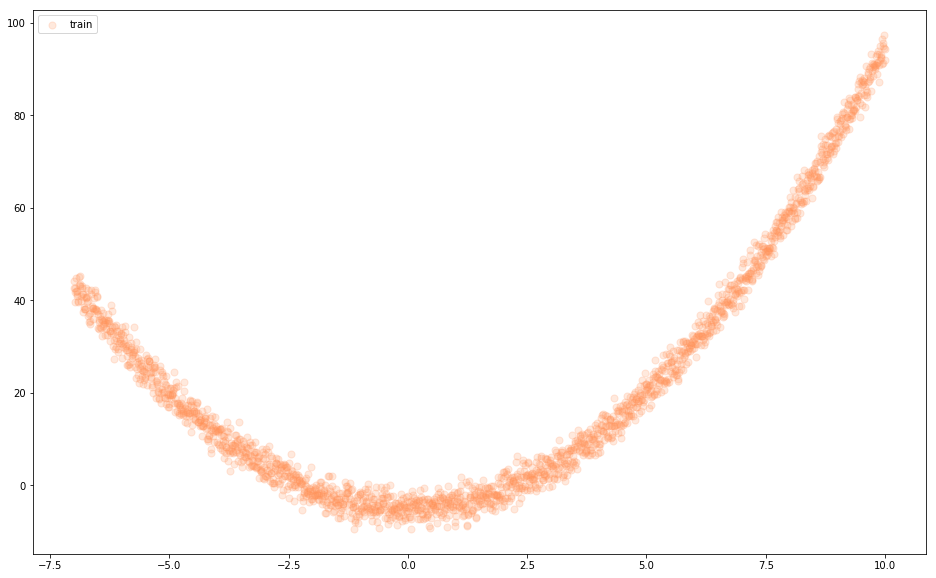

In [22]:
# training data
x = np.linspace(-7, 10, N_SAMPLES)[:, np.newaxis]  #dim为(2000,1)
noise = np.random.normal(loc=0, scale=2, size=x.shape)        # dim为(2000，1)，平均值为0，标准差为2的normalized的数
y = np.square(x) - 5 + noise

# test data
test_x = np.linspace(-7, 10, 200)[:, np.newaxis]   #dim为(200,1)
noise = np.random.normal(0, 2, test_x.shape)
test_y = np.square(test_x) - 5 + noise

train_x, train_y = torch.from_numpy(x).float(), torch.from_numpy(y).float()
test_x,test_y = torch.from_numpy(test_x).float(),torch.from_numpy(test_y).float()

# show data
plt.figure(figsize=(16,10))
plt.scatter(train_x.numpy(), train_y.numpy(), c='#FF9359', s=50, alpha=0.2, label='train')
plt.legend(loc='upper left')

train_dataset = Data.TensorDataset(train_x, train_y)  #把train_x和train_y合并成数据集形式
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,) # load data

In [39]:
# define net
class Net(nn.Module):
    def __init__(self,batch_normalization=False):       #可以选择net是否需要BN
        super(Net,self).__init__()
        self.do_bn = batch_normalization
        self.fcs = []          #用来装fully connected layer
        self.bns = []          #用来装batch normalization
        #下面开始来定义神经层，神经层都必须是self形式的
        # input BN layer
        self.bn_input = nn.BatchNorm1d(1, momentum=0.5)   # 标准化层，1d针对1维/2维（2/3个输出特征），此外还有2d（3维度），3d（4维度），
                                                          # 1表示num_features为1，momentum表示更新扩展参数gamma和平移参数beta的幅度
        # hidden layer and BN layer for hidden layer
        for i in range(N_HIDDEN):
            input_size = 1 if i == 0 else 10    # 第一个中间层层稍微不一样
            fc = nn.Linear(input_size, 10)
            setattr(self, 'fc%i' % i, fc)       # IMPORTANT set layer to the Module，setattr表示设置attribute，即self这种，
                                                # 这表示设置了fc0,fc1...
            self.fcs.append(fc)                 # 把fc0,fc1...都加入到list中
            if self.do_bn:
                bn = nn.BatchNorm1d(10, momentum=0.5)
                setattr(self, 'bn%i' % i, bn)   # IMPORTANT set layer to the Module
                self.bns.append(bn)             # 把bn0,bn1...都加入到list中
                
        # output layer
        self.predict = nn.Linear(10, 1)         # output layer
        
    def forward(self, x):   #out是最终结果，layer_input是每个层经过BN和ACTIVATION的结果，pre_activation是每个层没经过BN和ACTIVATION的结果
        if self.do_bn: x = self.bn_input(x)     # input batch normalization
        for i in range(N_HIDDEN):
            x = self.fcs[i](x)
            if self.do_bn: x = self.bns[i](x)   # batch normalization
            x = ACTIVATION(x)                   # actionvation
        out = self.predict(x)
        return out
    
nets = [Net(batch_normalization=False), Net(batch_normalization=True)]  #设立两个神经网络作比较
print(*nets)

Net(
  (bn_input): BatchNorm1d(1, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=1, out_features=10, bias=True)
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=10, bias=True)
  (fc6): Linear(in_features=10, out_features=10, bias=True)
  (fc7): Linear(in_features=10, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
) Net(
  (bn_input): BatchNorm1d(1, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=1, out_features=10, bias=True)
  (bn0): BatchNorm1d(10, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.5, af

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11


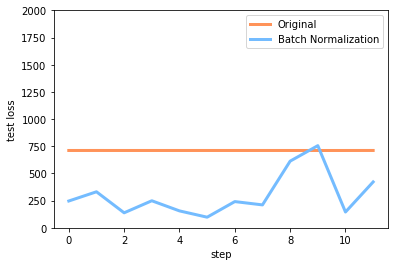

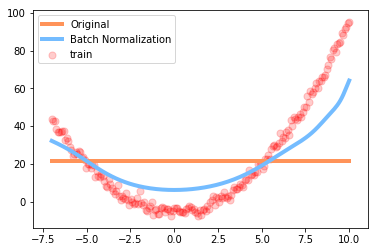

In [54]:
opts = [torch.optim.Adam(net.parameters(), lr=LR) for net in nets]
loss_func = torch.nn.MSELoss()

losses = [[], []]  # 每个网络一个 list 来记录误差
for epoch in range(EPOCH):
    print('Epoch: ', epoch)
    layer_inputs, pre_acts = [], []
    for net, l in zip(nets, losses):
        net.eval()              # set eval mode to fix moving_mean and moving_var，设置成预测模式，这一步在BN和Dropout预测时很重要！！
        pred = net(test_x)
        l.append(loss_func(pred, test_y).data.item())
        net.train()             # free moving_mean and moving_var
    
    # 训练两个网络
    for step, (b_x, b_y) in enumerate(train_loader):        
        for net, opt in zip(nets, opts):     
            pred = net(b_x)
            loss = loss_func(pred, b_y)
            opt.zero_grad()
            loss.backward()
            opt.step()    # 这也会训练 BN 里面的参数

# plot training loss
plt.figure(2)
plt.plot(losses[0], c='#FF9359', lw=3, label='Original')
plt.plot(losses[1], c='#74BCFF', lw=3, label='Batch Normalization')
plt.xlabel('step');plt.ylabel('test loss');plt.ylim((0, 2000));plt.legend(loc='best')

# evaluation
# set net to eval mode to freeze the parameters in batch normalization layers
[net.eval() for net in nets]    # set eval mode to fix moving_mean and moving_var
preds = [net(test_x) for net in nets]
plt.figure(3)
plt.plot(test_x.data.numpy(), preds[0].data.numpy(), c='#FF9359', lw=4, label='Original')
plt.plot(test_x.data.numpy(), preds[1].data.numpy(), c='#74BCFF', lw=4, label='Batch Normalization')
plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='r', s=50, alpha=0.2, label='train')
plt.legend(loc='best')
plt.show()